In [1]:
import ray
import time
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
@ray.remote
class GymWorker:
    def __init__(self, env_name):
        self.env = gym.make(env_name)

    def run_steps(self, steps=1000):
        obs, _ = self.env.reset()
        total_reward = 0.0
        for _ in range(steps):
            action = self.env.action_space.sample()
            obs, reward, terminated, truncated, _ = self.env.step(action)
            total_reward += reward
            if terminated or truncated:
                obs, _ = self.env.reset()
        return total_reward

# Settings
env_name = "CartPole-v1"
num_actors_list = [1, 2, 4]
steps_per_actor = 1000
results = {}

for n in num_actors_list:
    actors = [GymWorker.remote(env_name) for _ in range(n)]
    start = time.time()
    ray.get([actor.run_steps.remote(steps_per_actor) for actor in actors])
    end = time.time()
    elapsed = end - start
    results[n] = elapsed
    print(f"{n} actors finished in {elapsed:.2f} seconds")

2025-04-22 07:04:29,577	INFO worker.py:1429 -- Using address ray://192.168.122.10:10001 set in the environment variable RAY_ADDRESS


1 actors finished in 1.75 seconds
2 actors finished in 3.57 seconds
4 actors finished in 10.59 seconds


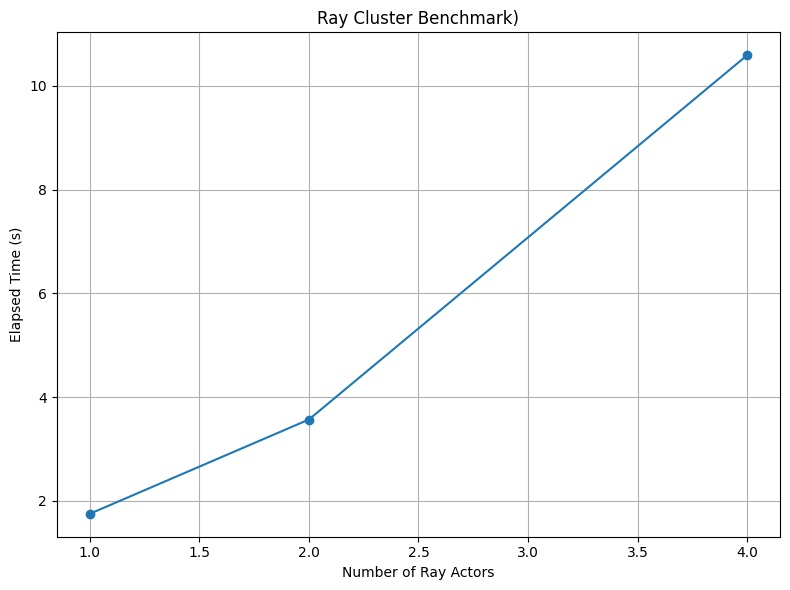

In [3]:
plt.figure(figsize=(8, 6))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.title("Ray Cluster Benchmark)")
plt.xlabel("Number of Ray Actors")
plt.ylabel("Elapsed Time (s)")
plt.grid(True)
plt.tight_layout()
plt.show()